In [1]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import diffrax as dfx

from flex import FuzzyVariable
from flex.fiss import TSK
from flex.utils import count_parameters
from flex.utils.types import Array

In [2]:
# taken from https://docs.kidger.site/diffrax/examples/neural_ode/
# def _get_data(ts, *, key):
#     y0 = jax.random.uniform(key, (2,), minval=-0.6, maxval=1)

#     def f(t, y, args):
#         x = y / (1 + y)
#         return jnp.stack([x[1], -x[0]], axis=-1)

#     solver = dfx.Tsit5()
#     dt0 = 0.1
#     saveat = dfx.SaveAt(ts=ts)
#     sol = dfx.diffeqsolve(
#         dfx.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
#     )
#     ys = sol.ys
#     return ys

# def get_data(dataset_size, *, key):
#     ts = jnp.linspace(0, 10, 100)
#     key = jax.random.split(key, dataset_size)
#     ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
#     return ts, ys

# def dataloader(arrays, batch_size, *, key):
#     dataset_size = arrays[0].shape[0]
#     assert all(array.shape[0] == dataset_size for array in arrays)
#     indices = jnp.arange(dataset_size)
#     while True:
#         perm = jax.random.permutation(key, indices)
#         (key,) = jax.random.split(key, 1)
#         start = 0
#         end = batch_size
#         while end < dataset_size:
#             batch_perm = perm[start:end]
#             yield tuple(array[batch_perm] for array in arrays)
#             start = end
#             end = start + batch_size

In [3]:
def run_random_traj(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1.0)

    def f(t, y, args):
        x = y / (y + 1.0)
        return jnp.stack([x[1], -x[0]])

    sol = dfx.diffeqsolve(
        dfx.ODETerm(f),
        dfx.Tsit5(),
        ts[0],
        ts[-1],
        0.1,
        y0,
        saveat=dfx.SaveAt(ts=ts)
    )

    return sol.ys

In [4]:
def get_data(dataset_size, *, key):
    ts = jnp.linspace(0.0, 10.0, 100)
    keys = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: run_random_traj(ts, key=key))(keys)
    return ts, ys

In [5]:
def load_data(data, batch_size, *, key):
    dataset_size = data[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in data)
    inds = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, inds)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in data)
            start = end
            end = start + batch_size

In [6]:
class Func(eqx.Module):
    fis: TSK

    def __init__(
        self,
        n_mfs: int,
        # kind: str,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        # y = (
        #     FuzzyVariable.ruspini(n_mfs, kind=kind, minval=-1.0, maxval=1.0, name="x"),
        #     FuzzyVariable.ruspini(n_mfs, kind=kind, minval=-1.0, maxval=1.0, name="xdot")
        # )
        y = (
            FuzzyVariable.gaussian(n_mfs, minval=-1.0, maxval=1.0, name="x"),
            FuzzyVariable.gaussian(n_mfs, minval=-1.0, maxval=1.0, name="xdot")
        )

        self.fis = TSK.init(
            input_vars=y,
            order=order,
            init_scale=init_scale,
            key=key,
            name="FODE",
        )
    
    def __call__(self, t, y, args):
        return self.fis(y).squeeze()  # expecting one output
        

In [7]:
class FuzzyODE(eqx.Module):
    func: Func

    def __init__(
        self,
        n_mfs: int,
        # kind: str,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.func = Func(
            n_mfs=n_mfs,
            # kind=kind,
            order=order,
            init_scale=init_scale,
            key=key,
        )
    
    def __call__(self, ts, y0):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(self.func),
            dfx.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=dfx.ConstantStepSize(),
            # stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts),
        )

        return sol.ys

In [12]:
dataset_size = 256
batch_size = 128
lr = 3e-3
steps_strategy = (2000,)# 500)
length_strategy = (1.0,)# 1.0)
seed = 12345
print_every = 100

n_mfs = 7
kind = "trapezoid"
order = 1
init_scale = 0.5

In [13]:
key = jax.random.PRNGKey(seed)
data_key, model_key, loader_key = jax.random.split(key, 3)

ts, ys = get_data(dataset_size, key=data_key)
_, length_size, _ = ys.shape

model = FuzzyODE(
    n_mfs=n_mfs,
    # kind=kind,
    order=order,
    init_scale=init_scale,
    key=model_key,
)
optim = optax.adam(learning_rate=lr)

In [14]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [15]:
for steps, length in zip(steps_strategy, length_strategy):
    opt_state = optim.init(model)
    _ts = ts[: int(length_size * length)]
    _ys = ys[:, : int(length_size * length)]
    for step, (yi,) in zip(
        range(steps), load_data((_ys,), batch_size, key=loader_key)
    ):
        start = perf_counter()
        loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        end = perf_counter()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 0, Loss: 0.48856669664382935, Computation time: 6.696715233000077
Step: 100, Loss: 0.4040740132331848, Computation time: 0.229076512000006
Step: 200, Loss: 0.3583061397075653, Computation time: 0.24489653600005568
Step: 300, Loss: 0.3370836675167084, Computation time: 0.2152360329999965
Step: 400, Loss: 0.3095395267009735, Computation time: 0.2080889759999991
Step: 500, Loss: 0.3350624740123749, Computation time: 0.246574973999941
Step: 600, Loss: 0.3204840123653412, Computation time: 0.20720068500008892
Step: 700, Loss: 0.3279840052127838, Computation time: 0.21821517700004733
Step: 800, Loss: 0.3155147433280945, Computation time: 0.22371593800005485
Step: 900, Loss: 0.32889631390571594, Computation time: 0.20947500900001614
Step: 1000, Loss: 0.3284803628921509, Computation time: 0.2513820729999452
Step: 1100, Loss: 0.33509621024131775, Computation time: 0.21064238800011026
Step: 1200, Loss: 0.3382611870765686, Computation time: 0.21410070299998551
Step: 1300, Loss: 0.3178312182

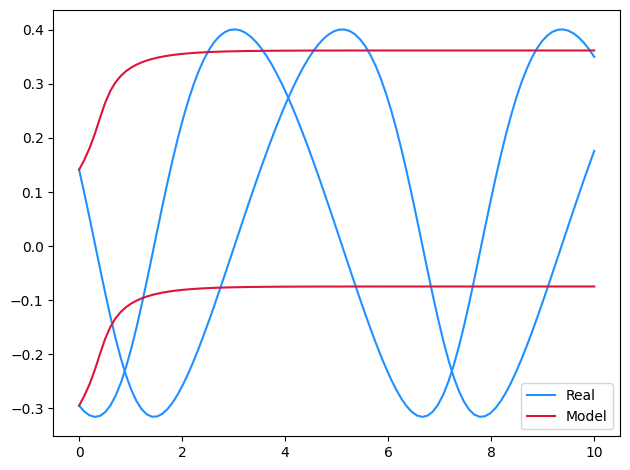

In [16]:
plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, ys[0, :, 1], c="dodgerblue")
model_y = model(ts, ys[0, 0])
plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.legend()
plt.tight_layout()
plt.savefig("neural_ode.png")
plt.show()